# Optimization Libraries

Mainly looking at them in context of hyperparameter tuning, but they are general libraries.

In [16]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [17]:
## Data

data = load_boston()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
477,15.02340,0.0,18.10,0.0,0.6140,5.304,97.3,2.1007,24.0,666.0,20.2,349.48,24.91
15,0.62739,0.0,8.14,0.0,0.5380,5.834,56.5,4.4986,4.0,307.0,21.0,395.62,8.47
332,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83
423,7.05042,0.0,18.10,0.0,0.6140,6.103,85.1,2.0218,24.0,666.0,20.2,2.52,23.29
19,0.72580,0.0,8.14,0.0,0.5380,5.727,69.5,3.7965,4.0,307.0,21.0,390.95,11.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.17120,0.0,8.56,0.0,0.5200,5.836,91.9,2.2110,5.0,384.0,20.9,395.67,18.66
270,0.29916,20.0,6.96,0.0,0.4640,5.856,42.1,4.4290,3.0,223.0,18.6,388.65,13.00
348,0.01501,80.0,2.01,0.0,0.4350,6.635,29.7,8.3440,4.0,280.0,17.0,390.94,5.99
435,11.16040,0.0,18.10,0.0,0.7400,6.629,94.6,2.1247,24.0,666.0,20.2,109.85,23.27


In [20]:
# Model we want to optimze

model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

6.560527271813469


In [22]:
## Hyperopt - Tree-Structured Parzen Estimation (Bayesian Estimation)

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK

def objective(params):
    MAX_DEPTH = params['max_depth']
    N_ESTIMATORS = params['n_estimators']
    LAMBDA = params['lambda']
    ALPHA = params['alpha']
    
    model = xgb.XGBRegressor(
        max_depth=MAX_DEPTH,
        n_estimators=N_ESTIMATORS,
        reg_lambda=LAMBDA,
        reg_alpha=ALPHA,
        verbosity=0,
        seed=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return {
        'loss': mse,
        'status': STATUS_OK,
        'params': params
    }

search_space = {
    'max_depth': hp.randint('max_depth', 1, 100),  # Default = 6
    'n_estimators': hp.randint('n_estimators', 1, 500),  # Default = 100
    'lambda': hp.uniform('lambda', 0, 2),  # Default = 1
    'alpha': hp.uniform('alpha', 0, 4),  # Default = 0
}

trials = Trials()  # allows us to record info from each iteration
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials
)

print(best)
# {'alpha': 0.7196749905956826, 'lambda': 0.8726803031598735, 'max_depth': 3, 'n_estimators': 420}

100%|██████████| 1000/1000 [01:28<00:00, 11.33trial/s, best loss: 4.66249309782992] 
{'alpha': 2.1777746488708605, 'lambda': 0.3949737375685849, 'max_depth': 50, 'n_estimators': 419}


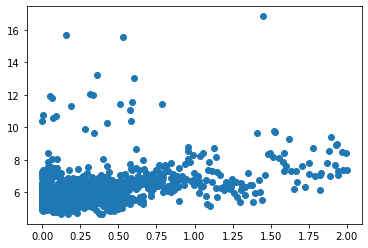

In [23]:
# Let's view Lambda (l2 reg)

x_chart = [x['result']['params']['lambda'] for x in trials.trials if x['result']['loss'] < 20]
y_chart = [x['result']['loss'] for x in trials.trials if x['result']['loss'] < 20]

plt.scatter(x_chart, y_chart)

In [30]:
## Evol - Genetic Approach

from evol import Population, Evolution

np.random.seed(42)

def population_start():
    """
    Init population with random starting conditions
    """
    max_depth = np.random.randint(low=1, high=100, size=None)
    n_estimators = np.random.randint(low=1, high=500, size=None)
    reg_lambda = np.random.uniform(low=0.0, high=2.0, size=None)
    reg_alpha = np.random.uniform(low=0.0, high=4.0, size=None)
    
    return max_depth, n_estimators, reg_lambda, reg_alpha

def objective(params):
    max_depth, n_estimators, reg_lambda, reg_alpha = params
    
    model = xgb.XGBRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        verbosity=0,
        seed=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse


def pick_parents(pop):
    """
    Pick random parents
    """
    mom = np.random.choice(pop, None)
    dad = np.random.choice(pop, None)
    return mom, dad


def make_child(mom, dad):
    """
    This function describes how two candidates combine into a new candidate.
    
    We'll just take the average of two parents
    """
    child_max_depth = int(np.round((mom[0] + dad[0])/2))
    child_n_estimators = int(np.round((mom[1] + dad[1])/2))
    child_reg_lambda = (mom[2] + dad[2])/2
    child_reg_alpha = (mom[3] + dad[3])/2
    
    return child_max_depth, child_n_estimators, child_reg_lambda, child_reg_alpha

def add_noise(chromosome, sigma):
    """
    This is a function that will add some noise to the chromosome.
    """
    new_max_depth = chromosome[0] + np.random.choice([-1, 1], None) * sigma
    new_n_estimators = chromosome[1] + np.random.choice([-1, 1], None) * sigma
    new_reg_lambda = chromosome[2] + (np.random.random_sample()-0.5) * sigma
    new_reg_alpha = chromosome[3] + (np.random.random_sample()-0.5) * sigma
    
    # check if see if in bounds
    new_max_depth = int(new_max_depth) if new_max_depth >= 1 else 1
    new_n_estimators = int(new_n_estimators) if new_n_estimators >= 1 else 1
    new_reg_lambda = new_reg_lambda if new_reg_lambda >= 0 else 0
    new_reg_alpha = new_reg_alpha if new_reg_alpha >= 0 else 0
    
    return new_max_depth, new_n_estimators, new_reg_lambda, new_reg_alpha

# We start by defining a population with candidates.
pop = Population(
    chromosomes=[population_start() for _ in range(200)],
    eval_function=objective,
    maximize=False
)

evo = (
    Evolution()
    .survive(fraction=0.5)
    .breed(parent_picker=pick_parents, combiner=make_child)
    .mutate(add_noise, probability=0.5, elitist=True, sigma=1)
    .evaluate()
)

for i in range(10):
    start = time.time()
    pop = pop.evolve(evo)
    end = time.time()
    delta = end - start
    
    print(f"iteration:{i+1} ({delta/60:0.2f}) best: {pop.current_best.fitness} worst: {pop.current_worst.fitness}")
    print(pop.current_best.chromosome)
    

iteration:1 (0.60) best: 4.539701602799563 worst: 10.038962710000352
(5, 103, 0.170694929987536, 0.2067268846744308)
iteration:2 (0.26) best: 4.829596472336706 worst: 8.628398210251838
(7, 59, 0.17188259278154028, 3.9739111660591013)
iteration:3 (0.28) best: 4.54766154963563 worst: 8.795063818649647
(49, 199, 0.179220855289429, 1.2051638047195405)
iteration:4 (0.24) best: 4.54766154963563 worst: 8.439148418831751
(49, 199, 0.179220855289429, 1.2051638047195405)
iteration:5 (0.25) best: 4.4963828948743085 worst: 8.042608473726155
(65, 169, 0.044912198482116694, 1.616958454170358)
iteration:6 (0.26) best: 4.54766154963563 worst: 8.029691108917476
(49, 199, 0.179220855289429, 1.2051638047195405)
iteration:7 (0.25) best: 4.581245217280008 worst: 8.093425777182812
(46, 183, 0.0, 0.9939520349784583)
iteration:8 (0.24) best: 4.5803741518467875 worst: 8.81246462998012
(63, 210, 0, 0.9637249887426494)
iteration:9 (0.24) best: 4.568507318347185 worst: 7.77228766794448
(48, 206, 0, 2.533076987707